# Objective
Run algorithm one step at a time to experiment with different versions

## Imports

In [2]:
%config Completer.use_jedi = True
# region Set up notebook imports
%load_ext autoreload
%autoreload 2
# Allow for imports of other scripts
import sys
PATH = "/data/MEAprojects/PropSignal"
if PATH not in sys.path:
    sys.path.append(PATH)
# Reload a module after changes have been made
from importlib import reload
# endregion

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, linkage
from tqdm import tqdm

from src.prop_signal import v1_4 as ps_alg
from src import plot

from src.sorters.prop_signal import PropSignal, PropUnit
from src.sorters.kilosort import Kilosort
from src.comparison import Comparison
from src import utils

from src.recording import Recording

## Load spike times and recording

In [3]:
# Load spike times
recording_path = utils.PATH_REC_DL.format("2953")
SPIKE_TIMES_PATH = "/data/MEAprojects/DLSpikeSorter/2953/prop_signal/thresh_5_full/crossings.npy"
##
recording = Recording(recording_path)
SPIKE_TIMES = np.load(SPIKE_TIMES_PATH, allow_pickle=True)
SPIKE_TIMES = PropSignal.format_thresh_crossings(SPIKE_TIMES)

## Create candidate cohorts

In [4]:
candidate_cohorts = ps_alg.scan_reference_electrode(SPIKE_TIMES, sampling_freq=20, min_prop_spikes=180, min_ccg_ratio=0.5,
                                                    ccg_before=1.5, ccg_after=1.5, ccg_small_window=0.5, ccg_big_window=2)

Scanning reference electrodes ...


100%|██████████| 1020/1020 [00:58<00:00, 17.30it/s]


## Form propagations

In [35]:
MIN_COCS_P_VALUES = range(0, 100)
##
nums_props = []

means_lens = []
stds_lens = []

means_durations = []
stds_durations = []
for min_cocs_p in MIN_COCS_P_VALUES:
    electrode_cohorts = ps_alg.rescan_candidate_cohorts(candidate_cohorts, max_latency=0.5,
                                                        min_cocs_n=0, min_cocs_p=min_cocs_p,
                                                        min_cocs_2_p=50)
    propagations = ps_alg.get_propagations(electrode_cohorts, min_duration=0.001)

    prop_lens = [len(p) for p in propagations]
    nums_props.append(len(prop_lens))

    if len(prop_lens) > 0:
        means_lens.append(np.mean(prop_lens))
        stds_lens.append(np.std(prop_lens))

        prop_durations = [PropSignal.get_sequence_duration(p) for p in propagations]
        means_durations.append(np.mean(prop_durations))
        stds_durations.append(np.std(prop_durations))
    else:
        means_lens.append(0)
        stds_lens.append(0)

        means_durations.append(0)
        stds_lens.append(0)

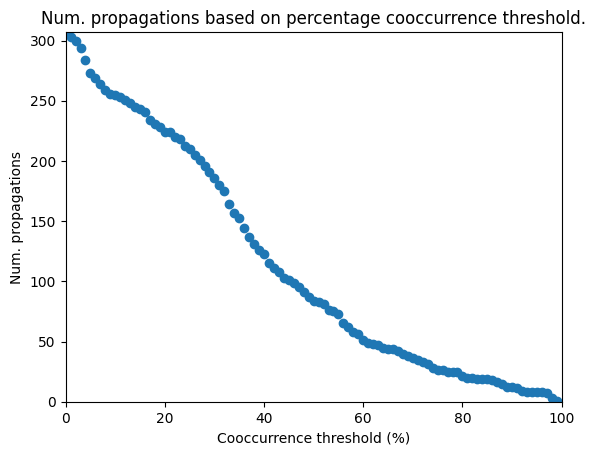

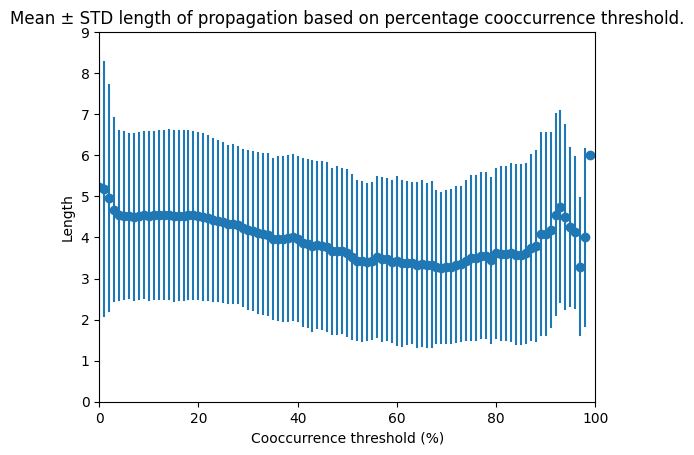

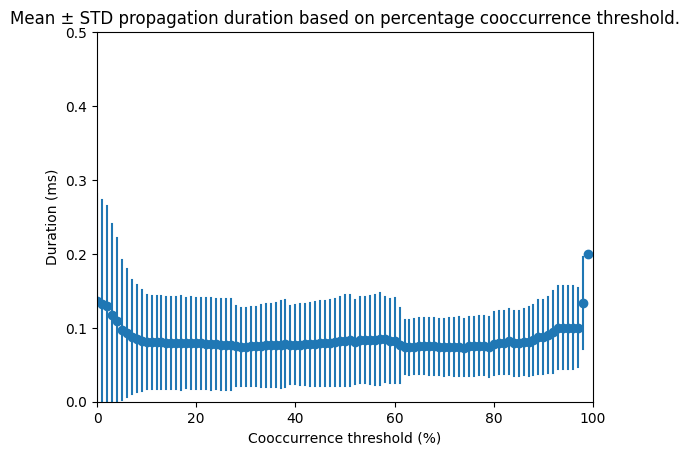

In [36]:
plt.title("Num. propagations based on percentage cooccurrence threshold.")
plt.xlabel("Cooccurrence threshold (%)")
plt.ylabel("Num. propagations")
plt.scatter(MIN_COCS_P_VALUES, nums_props)
plt.xlim(0, max(MIN_COCS_P_VALUES)+1)
plt.ylim(0, max(nums_props)+1)
plt.show()

plt.title("Mean ± STD length of propagation based on percentage cooccurrence threshold.")
plt.xlabel("Cooccurrence threshold (%)")
plt.ylabel("Length")
plt.scatter(MIN_COCS_P_VALUES, means_lens)
y_max = max(means_lens)+3
for thresh, mean, std in zip(MIN_COCS_P_VALUES, means_lens, stds_lens):
    plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max)
plt.xlim(0, max(MIN_COCS_P_VALUES)+1)
plt.ylim(0, y_max)
plt.show()

plt.title("Mean ± STD propagation duration based on percentage cooccurrence threshold.")
plt.xlabel("Cooccurrence threshold (%)")
plt.ylabel("Duration (ms)")
plt.scatter(MIN_COCS_P_VALUES, means_durations)
y_max = 0.5
for thresh, mean, std in zip(MIN_COCS_P_VALUES, means_durations, stds_durations):
    plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max)
plt.xlim(0, max(MIN_COCS_P_VALUES)+1)
plt.ylim(0, y_max)
plt.show()

In [ ]:
# # Sanity check that get_propagation gives same results as original
# %autoreload
# from src.prop_signal import v1
# props1 = v1.get_propagation(electrode_cohorts)
# for new, old in zip(propagations, props1):
#     if not np.all(new == old):
#         print(new)
#         print(old)
#         break

In [6]:
electrode_cohorts = ps_alg.rescan_candidate_cohorts(candidate_cohorts, max_latency=0.5,
                                                    min_cocs_n=0, min_cocs_p=30,
                                                    min_cocs_2_p=50)
propagations = ps_alg.get_propagations(electrode_cohorts, 0.001)
len(propagations)

186

## Merge propagations

In [7]:
def get_spike_times(propagations_merged):
    spike_times = np.array(SPIKE_TIMES[:], dtype=object)

    # Sort spike times
    # est_dtype = [('elec', int), ('st', float)]
    # elec_spike_times = []
    # for i, elec in enumerate(spike_times):
    #     elec_spike_times.extend((i, st) for st in elec)
    # elec_spike_times = np.sort(np.array(elec_spike_times, dtype=est_dtype), order="st")

    prop_after = 0.5  # Insignificant change when 1.5 --> 0.5 (mean 8988 to 8787)
    thresh_coactivations = 2
    isi_viol = 1.5

    propagating_times = []
    for prop_m in tqdm(propagations_merged):
        prop_m_times = []
        prop_m_ids = []
        for i, prop in enumerate(prop_m):
            if len(prop) < thresh_coactivations: continue

            ref_spike_times = spike_times[prop.ID[0]]
            tar_spike_times_all = []
            for elec in prop.ID[1:]:
                tar_spike_times = spike_times[elec]
                for ref in ref_spike_times:
                    if np.any((tar_spike_times >= ref) & (tar_spike_times <= ref + prop_after)):
                        tar_spike_times_all.append(ref)

            # zero_latencies = np.sum(prop.latency.values == 0)
            # tar_spike_times_all = []
            # for z in range(zero_latencies):
            #     ref_spike_times = spike_times[prop.ID[z]]
            #     for t in range(len(prop)):
            #         if z == t:
            #             continue
            #         tar_spike_times = spike_times[prop.ID[t]]
            #         for ref in ref_spike_times:
            #             if np.any((tar_spike_times >= ref) & (tar_spike_times <= ref + prop_after)):
            #                 tar_spike_times_all.append(ref)

            prop_spike_times, st_counts = np.unique(tar_spike_times_all, return_counts=True)
            prop_spike_times = prop_spike_times[st_counts >= thresh_coactivations-1] # -1 since just being in the list counts as 2 coactivations
            prop_m_times.extend(prop_spike_times)
            prop_m_ids.extend([i] * len(prop_spike_times))

        if len(prop_m_times) == 0: continue

        ind_sorted = np.argsort(prop_m_times)
        prop_m_times_curated = [prop_m_times[ind_sorted[0]]]
        for i in range(1, len(ind_sorted)):
            i0 = ind_sorted[i-1]
            i1 = ind_sorted[i]
            if prop_m_times[i1] - prop_m_times[i0] > isi_viol:
                prop_m_times_curated.append(prop_m_times[i1])

        # propagating_times.append(np.sort(list(prop_m_times)))
        propagating_times.append(prop_m_times_curated)
        
    return propagating_times

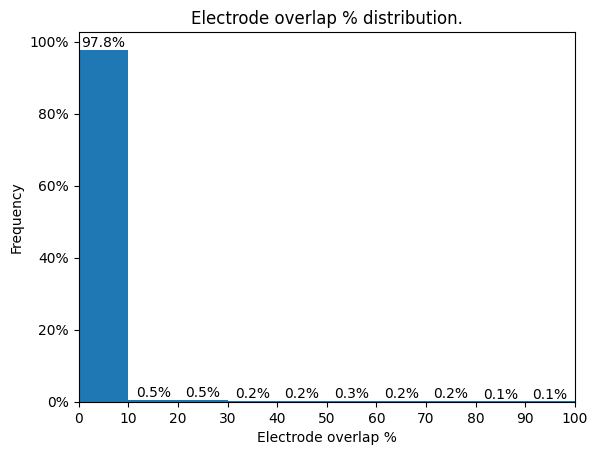

In [8]:
## Graph distribution of electrode overlap scores
scores = []
ind_a, ind_b = np.triu_indices(len(propagations), k=1)
for i_a, i_b in zip(ind_a, ind_b):
    prop_a = propagations[i_a]
    prop_b = propagations[i_b]
    scores.append(ps_alg.get_elec_overlap_score(propagations[i_a], propagations[i_b]) * 100)
# Create plot
plt.title("Electrode overlap % distribution.")
plt.xlabel("Electrode overlap %")
plot.plot_hist_percents(scores, bins=np.arange(0, 101, 10), labels=True)
plt.xlim(0, 100)
plt.xticks(np.arange(0, 101, 10))
plt.show()

### Development

#### Score histogram

In [9]:
## Get overlap and sequential scores
from IPython.display import display

scores = []
for a in range(len(propagations)):
    for b in range(a+1, len(propagations)):
        prop_a = propagations[a]
        prop_b = propagations[b]
        overlap = ps_alg.get_elec_overlap_score(prop_a, prop_b)
        sequential = ps_alg.get_seq_order_score(prop_a, prop_b)
        scores.append([overlap, sequential])

#         if sequential == 0:
#             print("-------")
#             print(a, b)
#             display(prop_a)
#             display(prop_b)

scores = np.array(scores)

In [10]:
sequential_scores = scores[scores[:, 0] >= 0.5, 1]

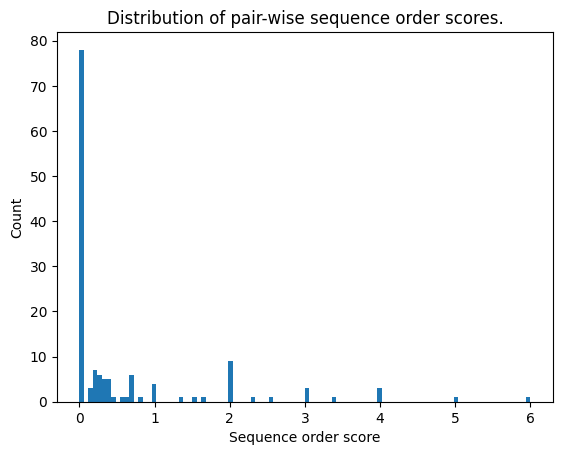

In [11]:
plt.title("Distribution of pair-wise sequence order scores.")
plt.hist(sequential_scores, bins=100, range=(np.min(sequential_scores), np.max(sequential_scores)))
# plt.hist(sequential_scores, bins=100, range=(0, 1))
plt.xlabel("Sequence order score")
plt.ylabel("Count")
plt.show()

In [12]:
np.sum(sequential_scores==0)

68

#### Score and merge methods

In [13]:
def get_elec_overlap(prop_a, prop_b):
    elec_a = prop_a.ID.values
    elec_b = prop_b.ID.values
    _, overlap_a, overlap_b = np.intersect1d(elec_a, elec_b, return_indices=True, assume_unique=True)
    return overlap_a, overlap_b

def get_elec_overlap_score(prop_a, prop_b):
    elec_a = prop_a.ID.values
    elec_b = prop_b.ID.values

    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    num_overlap = len(overlap_a)
    overlap_score = num_overlap / (len(elec_a) + len(elec_b) - num_overlap)
    return overlap_score

In [14]:
def get_matrix_binary(prop, overlap_ind):
    overlap_ind = set(overlap_ind)
    elecs = [prop.ID.values[e] for e in range(len(prop)) if e in overlap_ind]
    elecs = np.argsort(elecs)
    return np.clip(elecs - elecs[:, None], -1, 1)

def score_matrix_binary(prop_a, prop_b):
    # Construct sequential order matrix. Columns = reference. Rows = what reference is compared to. I.e. column rel. position - row rel. position
    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    num_overlap = len(overlap_a)

    matrix_a = get_matrix_binary(prop_a, overlap_a)
    matrix_b = get_matrix_binary(prop_b, overlap_b)

    div = num_overlap * num_overlap - num_overlap if num_overlap > 1 else 1
    seq_order_score = np.sum(matrix_a * matrix_b) / div
    return seq_order_score

In [15]:
def get_matrix_latency(prop, overlap_ind):
    latencies = prop.latency.values[overlap_ind]
    return latencies - latencies[:, None]

def score_matrix_latency(prop_a, prop_b):
    # Construct sequential order matrix. Columns = reference. Rows = what reference is compared to. I.e. column rel. position - row rel. position
    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    num_overlap = len(overlap_a)

    matrix_a = get_matrix_latency(prop_a, overlap_a)
    matrix_b = get_matrix_latency(prop_b, overlap_b)

    seq_order_score = np.sum(matrix_a * matrix_b) / (np.sum(prop_a.latency) + np.sum(prop_b.latency))
    return seq_order_score

In [16]:
def get_latency_pairs(latencies: np.ndarray):
    if latencies.size == 1:
        return latencies

    pairs = []
    for i in range(len(latencies)):
        for j in range(i+1, len(latencies)):
            pairs.append(latencies[i] - latencies[j])
    return np.asarray(pairs)

def score_sub(prop_a, prop_b):
    overlap_a, overlap_b = get_elec_overlap(prop_a, prop_b)
    if overlap_a.size == 0:
        return np.nan

    latencies_a = prop_a.latency.values[overlap_a]
    latencies_b = prop_b.latency.values[overlap_b]
    sums = np.sum(latencies_a) + np.sum(latencies_b)
    if sums < 0.0001:
        return 0

    pairs_a = get_latency_pairs(latencies_a)
    pairs_b = get_latency_pairs(latencies_b)
    seq_score = np.sum(np.abs(pairs_a - pairs_b))
    return seq_score / sums

In [17]:
def get_merge_scores(merge_method):
    merge_scores = []
    ind_a, ind_b = np.triu_indices(len(propagations), k=1)
    for i_a, i_b in zip(ind_a, ind_b):
        prop_a = propagations[i_a]
        prop_b = propagations[i_b]

        overlap_score = get_elec_overlap_score(prop_a, prop_b)
        if overlap_score > 0:
            seq_score = merge_method(prop_a, prop_b)
        else:
            seq_score = np.nan

        merge_scores.append([overlap_score, seq_score])
    return np.asarray(merge_scores)

In [18]:
def get_pdist_from_merge_scores(merge_scores, elec_overlap_min, extremum):
    pdist = merge_scores[:, 1]
    pdist[merge_scores[:, 0] < elec_overlap_min] = extremum
    return pdist

In [19]:
def get_pdist_from_merge_scores_comb(merge_scores, elec_overlap_min, extremum):
    pdist = merge_scores[:, 1]
    pdist[merge_scores[:, 0] < elec_overlap_min] = extremum
    pdist += 1 - merge_scores[:, 0]
    return pdist

In [20]:
def merge(pdist, seq_order_thresh,
          method, criterion):
    linkage_m = linkage(pdist, method=method)
    clusters = fcluster(linkage_m, seq_order_thresh, criterion=criterion)
    propagations_merged = {}
    for i, c in enumerate(clusters):
        if c not in propagations_merged:
            propagations_merged[c] = [propagations[i]]
        else:
            propagations_merged[c].append(propagations[i])

    propagations_merged = list(propagations_merged.values())
    return propagations_merged

#### Comparing merging methods

In [21]:
ELEC_OVERLAP_MIN = 0.5

METHOD = "single"
CRITERION = "distance"

#### Binary matrix

Num. propagations: 186
Elec overlap min: 0.5


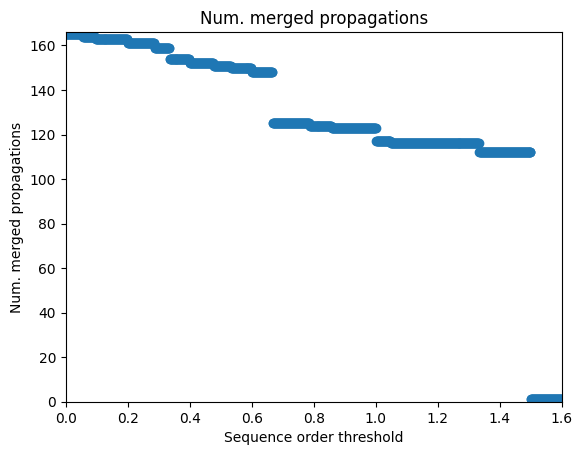

In [22]:
SEQ_ORDER_VALUES = np.linspace(0, 1.6, num=1000)

MERGE_SCORES = get_merge_scores(score_matrix_binary)
MERGE_SCORES[:, 1] = 1 - MERGE_SCORES[:, 1]
PDIST = get_pdist_from_merge_scores(MERGE_SCORES, ELEC_OVERLAP_MIN, 1.5)
##

nums_merges = []
means_lens = []
stds_lens = []
for seq_order in SEQ_ORDER_VALUES:
    prop_lens = [len(p) for p in merge(PDIST, seq_order,
                                       METHOD, CRITERION)]
    nums_merges.append(len(prop_lens))
    if len(prop_lens) > 0:
        means_lens.append(np.mean(prop_lens))
        stds_lens.append(np.std(prop_lens))
    else:
        means_lens.append(0)
        stds_lens.append(0)

print(f"Num. propagations: {len(propagations)}")
print(f"Elec overlap min: {ELEC_OVERLAP_MIN}")

# Create plot
# plt.title("Num. merged propagations based on percentage sequence order overlap.")
plt.title("Num. merged propagations")
# plt.xlabel("Sequence order threshold (%)")
plt.xlabel("Sequence order threshold")
plt.ylabel("Num. merged propagations")
plt.scatter(SEQ_ORDER_VALUES, nums_merges)
plt.xlim(min(SEQ_ORDER_VALUES), max(SEQ_ORDER_VALUES))
plt.ylim(0, max(nums_merges)+1)
plt.show()

# plt.title("Mean ± STD num. propagations in a merge")
# plt.xlabel("Sequence order threshold")
# plt.ylabel("Num. propagations in merge")
# plt.scatter(SEQ_ORDER_VALUES, means_lens)
# y_max = 2.5  # means_lens[1] + 1
# for thresh, mean, std in zip(SEQ_ORDER_VALUES, means_lens, stds_lens):
#     plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max, alpha=0.1)
# plt.xlim(min(SEQ_ORDER_VALUES), max(SEQ_ORDER_VALUES))
# plt.ylim(0, y_max)
# plt.show()

In [ ]:
# pm_binary = merge(PDIST, 1.4, METHOD, CRITERION)
# print(len(pm_binary))
# pm_binary_times = get_spike_times(pm_binary)
# ps_binary = PropSignal((pm_binary, pm_binary_times), recording)

#### Latency matrix

Num. propagations: 186
Elec overlap min: 0.5


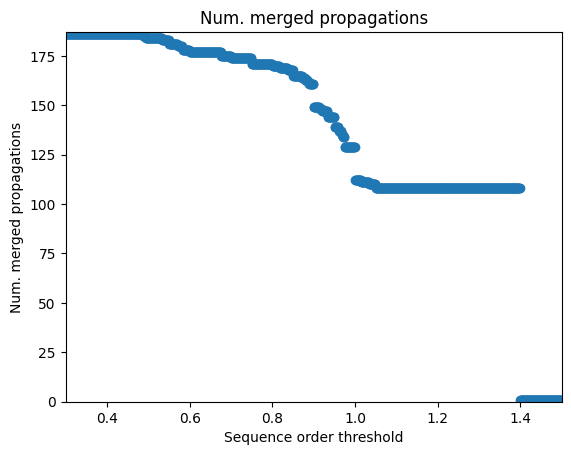

In [23]:
SEQ_ORDER_VALUES = np.linspace(0.3, 1.5, num=1000)

MERGE_SCORES = get_merge_scores(score_matrix_latency)
MERGE_SCORES[:, 1] = 1 - MERGE_SCORES[:, 1]
PDIST = get_pdist_from_merge_scores(MERGE_SCORES, ELEC_OVERLAP_MIN, 1.4)
##

nums_merges = []
means_lens = []
stds_lens = []
for seq_order in SEQ_ORDER_VALUES:
    prop_lens = [len(p) for p in merge(PDIST, seq_order,
                                       METHOD, CRITERION)]
    nums_merges.append(len(prop_lens))
    if len(prop_lens) > 0:
        means_lens.append(np.mean(prop_lens))
        stds_lens.append(np.std(prop_lens))
    else:
        means_lens.append(0)
        stds_lens.append(0)

print(f"Num. propagations: {len(propagations)}")
print(f"Elec overlap min: {ELEC_OVERLAP_MIN}")

# Create plot
# plt.title("Num. merged propagations based on percentage sequence order overlap.")
plt.title("Num. merged propagations")
# plt.xlabel("Sequence order threshold (%)")
plt.xlabel("Sequence order threshold")
plt.ylabel("Num. merged propagations")
plt.scatter(SEQ_ORDER_VALUES, nums_merges)
plt.xlim(min(SEQ_ORDER_VALUES), max(SEQ_ORDER_VALUES))
plt.ylim(0, max(nums_merges)+1)
plt.show()

# plt.title("Mean ± STD num. propagations in a merge")
# plt.xlabel("Sequence order threshold")
# plt.ylabel("Num. propagations in merge")
# plt.scatter(SEQ_ORDER_VALUES, means_lens)
# y_max = 2.5  # means_lens[1] + 1
# for thresh, mean, std in zip(SEQ_ORDER_VALUES, means_lens, stds_lens):
#     plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max, alpha=0.1)
# plt.xlim(min(SEQ_ORDER_VALUES), max(SEQ_ORDER_VALUES))
# plt.ylim(0, y_max)
# plt.show()

In [ ]:
# pm_latency = merge(PDIST, 1.2, METHOD, CRITERION)
# print(len(pm_latency))
# pm_latency_times = get_spike_times(pm_latency)
# ps_latency = PropSignal((pm_latency, pm_latency_times), recording)

#### Subtraction

Num. propagations: 186
Elec overlap min: 0.5


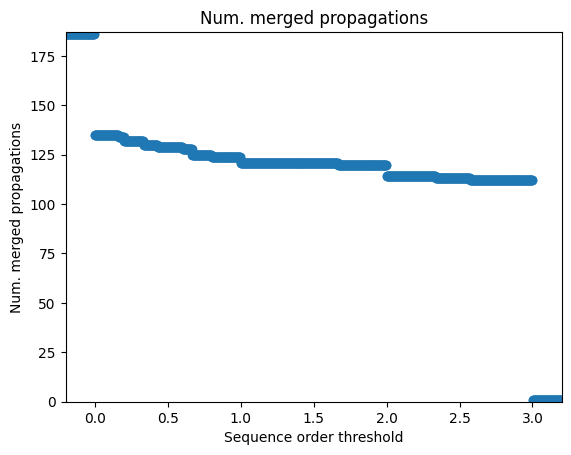

In [24]:
SEQ_ORDER_VALUES = np.linspace(-0.2, 3.2, num=1000)
ELEC_OVERLAP_MIN = 0.5

MERGE_SCORES = get_merge_scores(score_sub)
PDIST = get_pdist_from_merge_scores(MERGE_SCORES, ELEC_OVERLAP_MIN, 3)
##

nums_merges = []
means_lens = []
stds_lens = []
for seq_order in SEQ_ORDER_VALUES:
    prop_lens = [len(p) for p in merge(PDIST, seq_order,
                                       METHOD, CRITERION)]
    nums_merges.append(len(prop_lens))
    if len(prop_lens) > 0:
        means_lens.append(np.mean(prop_lens))
        stds_lens.append(np.std(prop_lens))
    else:
        means_lens.append(0)
        stds_lens.append(0)

print(f"Num. propagations: {len(propagations)}")
print(f"Elec overlap min: {ELEC_OVERLAP_MIN}")

# Create plot
# plt.title("Num. merged propagations based on percentage sequence order overlap.")
plt.title("Num. merged propagations")
# plt.xlabel("Sequence order threshold (%)")
plt.xlabel("Sequence order threshold")
plt.ylabel("Num. merged propagations")
plt.scatter(SEQ_ORDER_VALUES, nums_merges)
plt.xlim(min(SEQ_ORDER_VALUES), max(SEQ_ORDER_VALUES))
plt.ylim(0, max(nums_merges)+1)
plt.show()

# plt.title("Mean ± STD num. propagations in a merge")
# plt.xlabel("Sequence order threshold")
# plt.ylabel("Num. propagations in merge")
# plt.scatter(SEQ_ORDER_VALUES, means_lens)
# y_max = 2.5  # means_lens[1] + 1
# for thresh, mean, std in zip(SEQ_ORDER_VALUES, means_lens, stds_lens):
#     plt.axvline(thresh, (mean-std)/y_max, (mean+std)/y_max, alpha=0.1)
# plt.xlim(min(SEQ_ORDER_VALUES), max(SEQ_ORDER_VALUES))
# plt.ylim(0, y_max)
# plt.show()

In [25]:
pm_sub = merge(PDIST, 0.2, METHOD, CRITERION)
print(len(pm_sub))
pm_sub_times = get_spike_times(pm_sub)
ps_sub = PropSignal((pm_sub, pm_sub_times), recording)

133


100%|██████████| 133/133 [00:02<00:00, 52.00it/s]


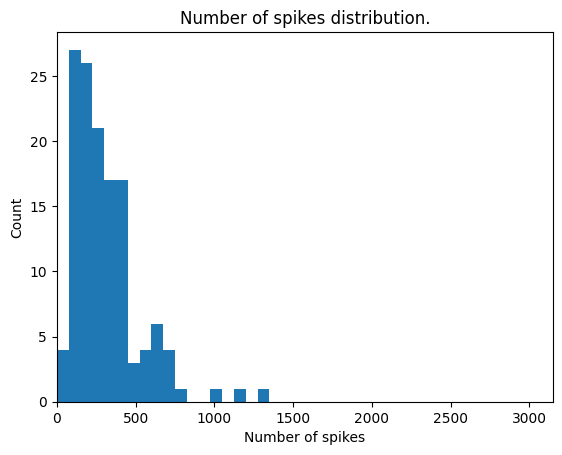

Mean: 309.39
STD: 209.41


In [26]:
ps_sub.plot_nums_spikes(bins=40, range=(0, 3000))
plt.show()

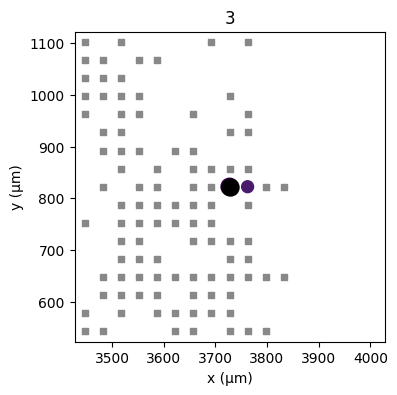

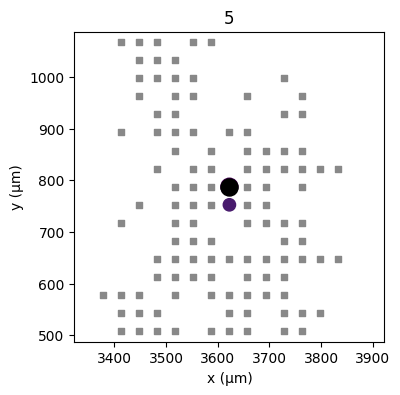

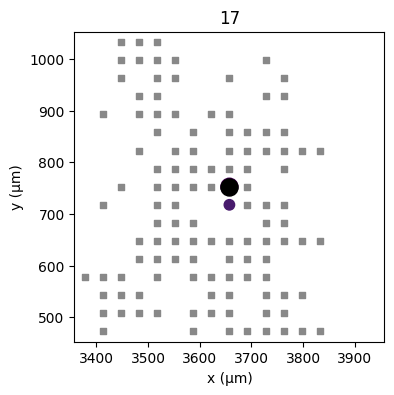

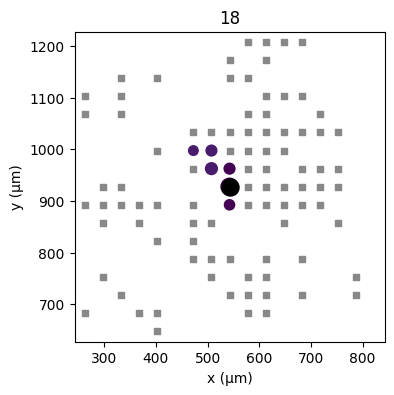

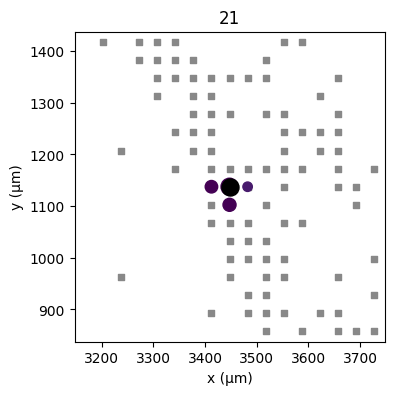

KeyboardInterrupt: 

In [27]:
for pm in ps_sub:
    pm.plot()

### Visualize Latencies

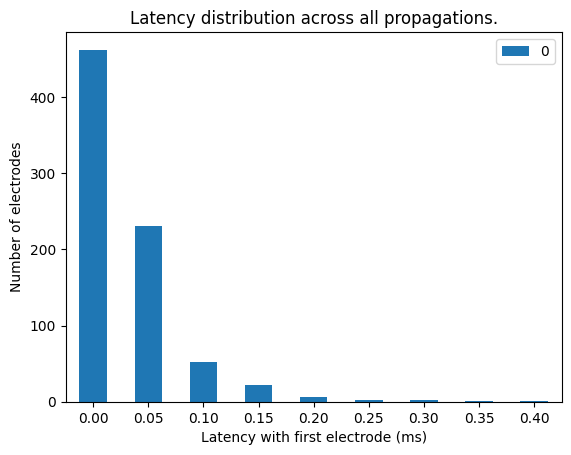

In [28]:
## Plot histogram of inter-electrode latencies
latencies = []
for prop in propagations:
    latencies.extend(prop.latency.values)
latencies, counts = np.unique(latencies, return_counts=True)
from pandas import DataFrame
df = DataFrame(counts, index=[f"{l:.2f}" for l in latencies])
df.plot.bar(rot=0)
plt.title("Latency distribution across all propagations.")
plt.xlabel("Latency with first electrode (ms)")
plt.ylabel("Number of electrodes")
plt.show()

## Comparison with Kilosort2

In [ ]:
# Load sorter
# ps_old = PropSignal("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/230423", recording)
# prop_signal.plot_nums_spikes(show=False, bins=20)
# plt.xlim(0, 40000)
# plt.show()
# prop_signal.save("/data/MEAprojects/dandi/000034/sub-mouse412804/prop_signal/230423")

Mean: 248.11
STD: 305.99


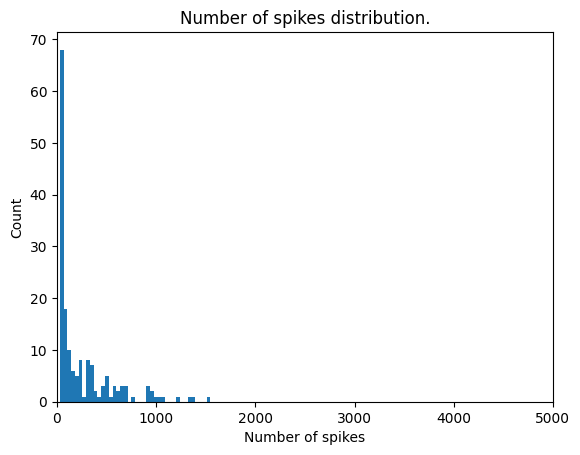

In [29]:
# Load kilosort
kilosort = Kilosort(utils.PATH_SM4_DL.format("2953"), "first", recording)
kilosort.plot_nums_spikes(show=False, bins=40)
plt.xlim(0, 5000)
plt.show()

Getting spike times
Getting match counts and agreement scores


100%|██████████| 133/133 [00:01<00:00, 111.77it/s]


Num Prop.: 133
Num Kilosort2: 167
Num single matches: 18

For Prop.:
Num max matches: 20
Num unique max matches: 18

For Kilosort2:
Num max matches: 18
Num unique max matches: 18


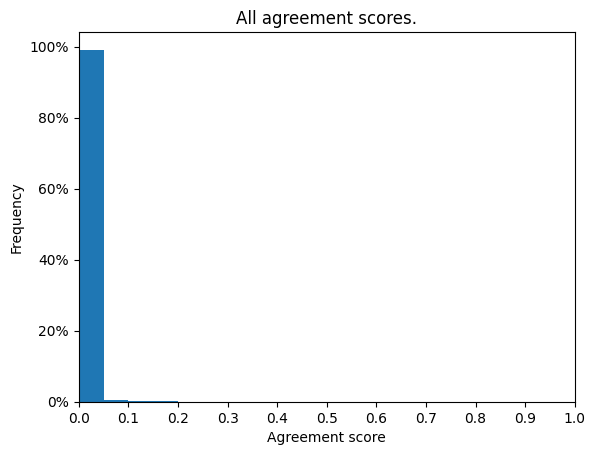

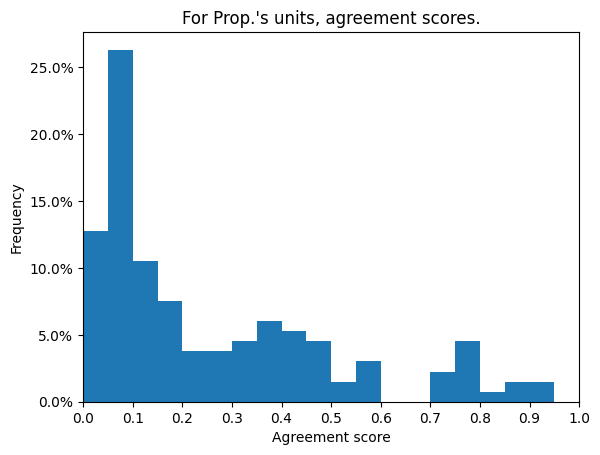

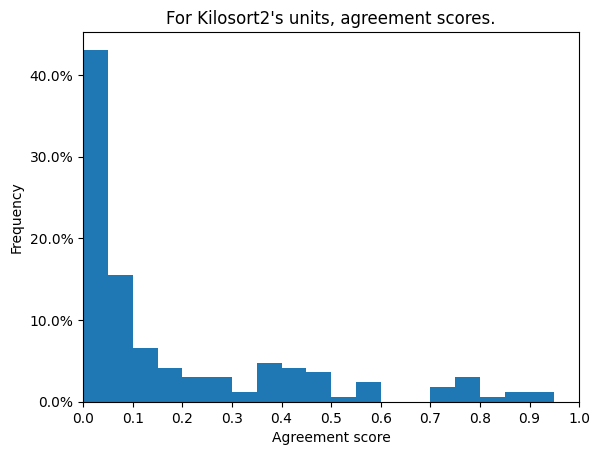

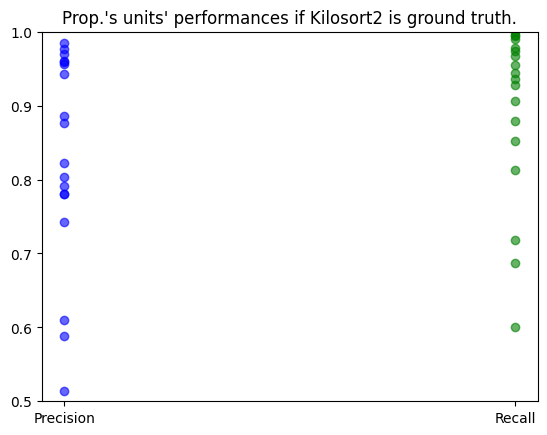

Getting spike times
Getting match counts and agreement scores


100%|██████████| 133/133 [00:01<00:00, 121.34it/s]


Num Prop.: 133
Num Kilosort2: 167
Num single matches: 38

For Prop.:
Num max matches: 46
Num unique max matches: 38

For Kilosort2:
Num max matches: 38
Num unique max matches: 38


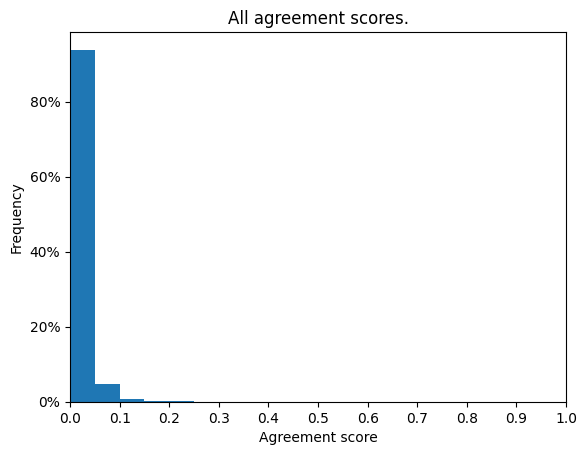

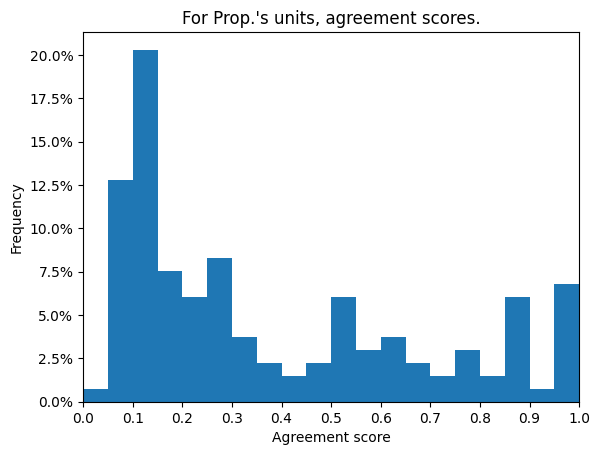

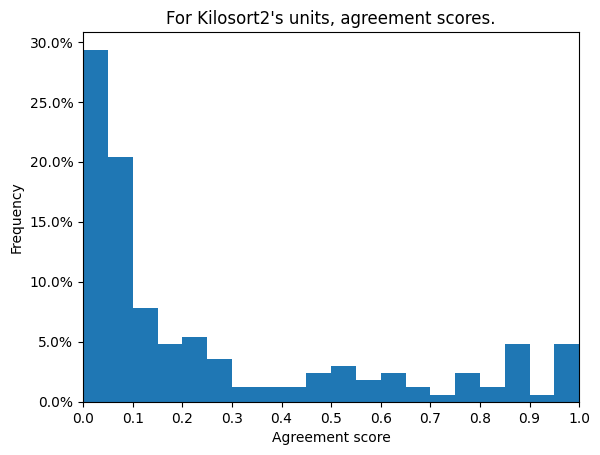

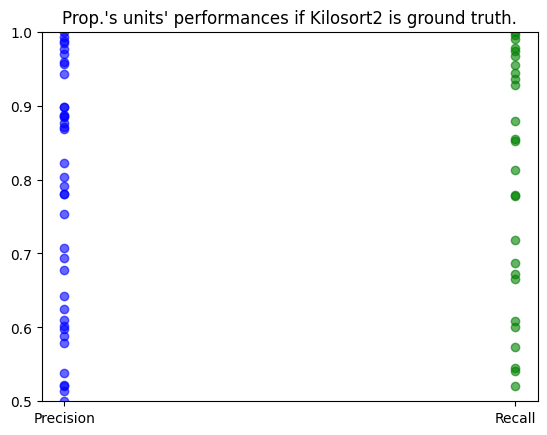

Getting spike times
Getting match counts and agreement scores


100%|██████████| 133/133 [00:01<00:00, 116.06it/s]

Num Prop.: 133
Num Kilosort2: 167
Num single matches: 59

For Prop.:
Num max matches: 71
Num unique max matches: 52

For Kilosort2:
Num max matches: 68
Num unique max matches: 52


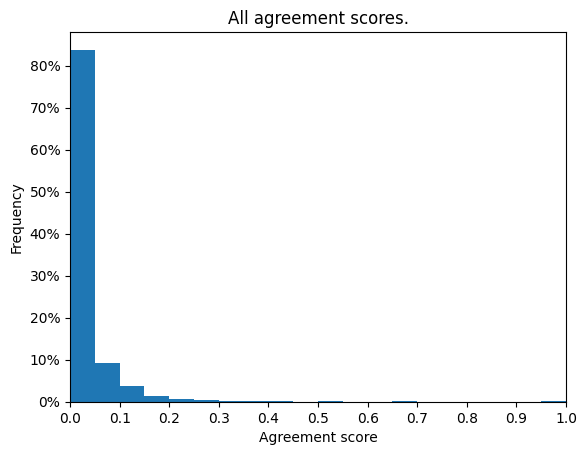

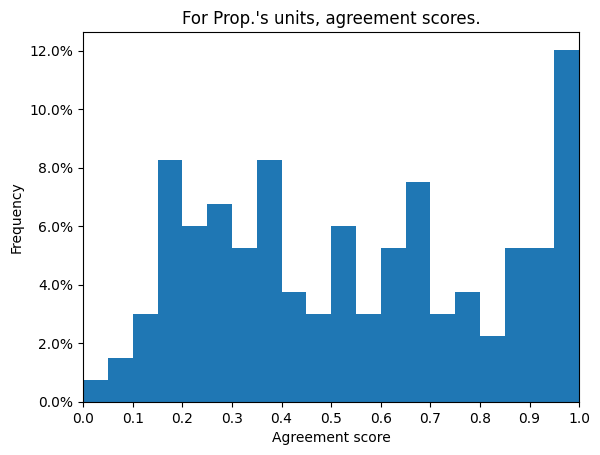

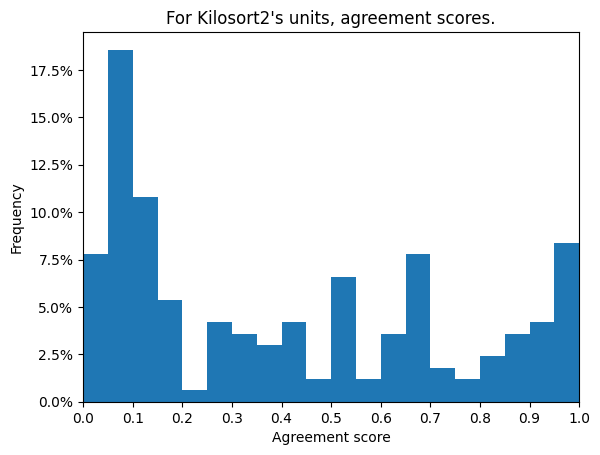

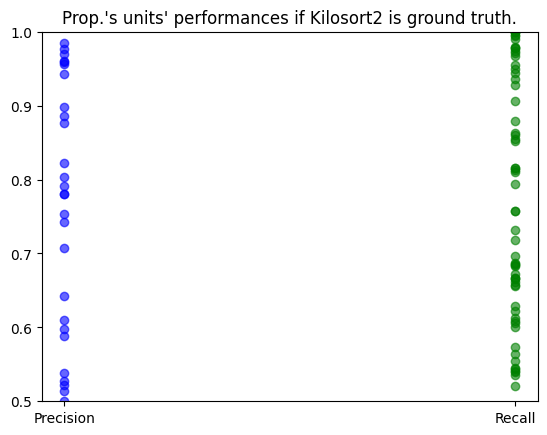

In [30]:
comp_1_5 = Comparison(ps_sub, kilosort, score_formula=1.5)
comp_1 = Comparison(ps_sub, kilosort, score_formula=1)
comp_2 = Comparison(ps_sub, kilosort, score_formula=2)

### Line comparison

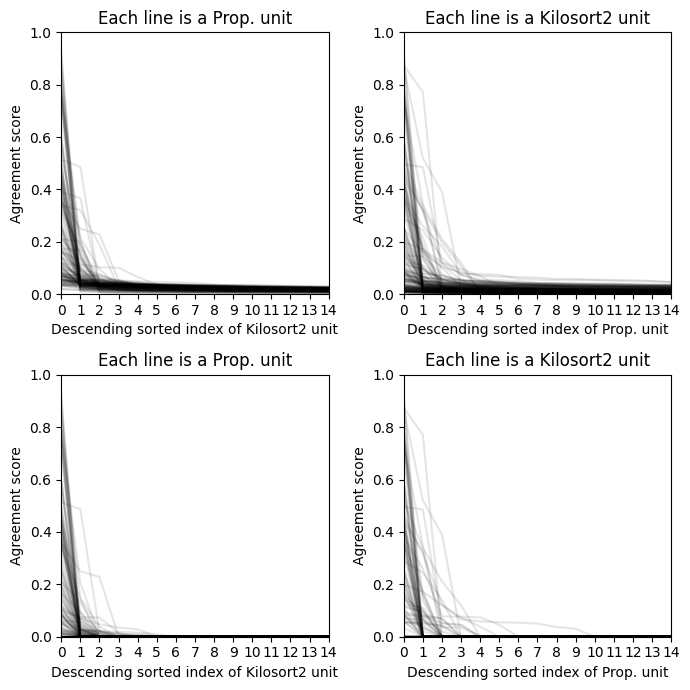

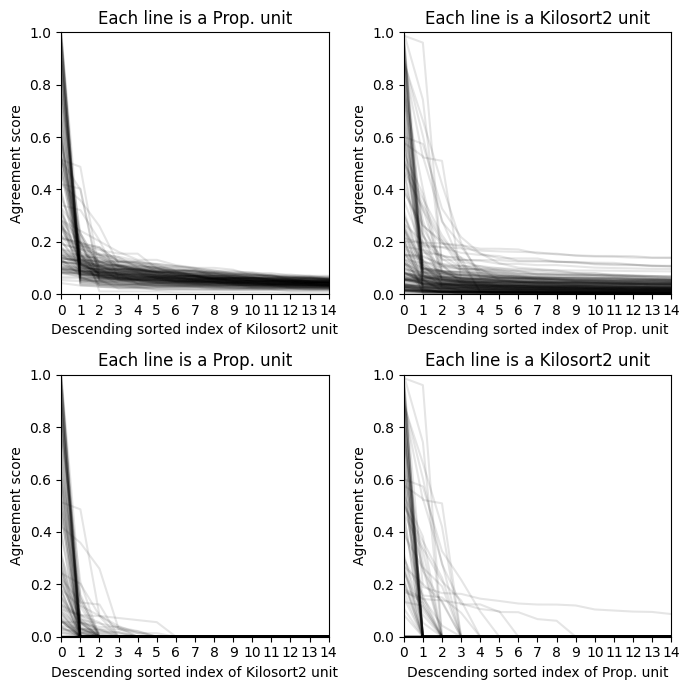

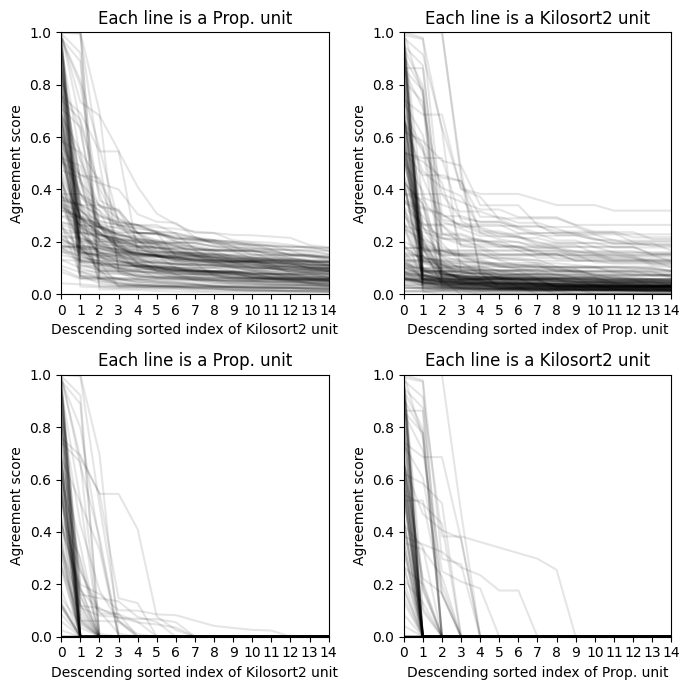

In [33]:
comp_1_5.plot_line_comps()
comp_1.plot_line_comps()
comp_2.plot_line_comps()

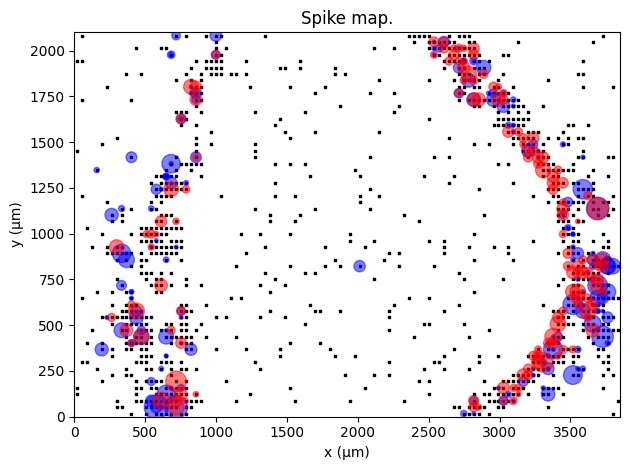

In [32]:
comp_1_5.plot_spike_map()

#### Investigation
Figure out why agreement scores are so low

In [387]:
recording = Recording(recording_path, freq_min=300, freq_max=3000)

/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.1 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/hdmf/spec/namespace.py:532: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
/home/mea/anaconda3/envs/allen_inst/lib/python3.7/site-packages/pynwb/ecephys.py:93: UserWarning: ElectricalSeries 'ElectricalSeries': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  "Your data may be transposed." % (self.__class__.__name__, kwargs["name"]))


In [490]:
IDX = 0
spike_times_prop = comp_1.spike_times_matching1[IDX]
spike_times_ks = comp_1.spike_times_matching2[IDX]
uid_prop, uid_ks = comp_1.matching_uids[IDX]
unit_ks = kilosort[uid_ks]

In [491]:
prop = propagations_merged[uid_prop]
prop

[   ID  latency  small_window_cooccurrences  n1_n2_ratio
 0   0      0.0                      5500.0     1.000000
 1   1      0.1                      2545.0     0.975844,
    ID   latency  small_window_cooccurrences  n1_n2_ratio
 0   2  0.000000                      7016.0     1.000000
 1   4  0.000000                      3809.0     0.993479
 2   0  0.033333                      4095.0     0.998537
 3   1  0.133333                      4073.0     0.984530]

In [163]:
num_matches, agreement = Comparison.get_match_count_and_agreement_scores([spike_times_prop], [spike_times_ks])
num_matches = num_matches.flatten()[0]
agreement = agreement.flatten()[0]
print(f"Agreement score: {agreement:.3f}")
print(f"Matches/Prop: {num_matches/len(spike_times_prop):.3f}")
print(f"Matches/KS: {num_matches/len(spike_times_ks):.3f}")

NameError: name 'spike_times_prop' is not defined

In [493]:
DELTA_TIME = 0.4
false_negs = []  # Spikes detected by kilosort and not by prop and closest spike times by prop
for st_ks in spike_times_ks:
    i = np.searchsorted(spike_times_prop, st_ks)
    if (i == 0 or st_ks - spike_times_prop[i-1] > DELTA_TIME) and (i == len(spike_times_prop) or spike_times_prop[i] - st_ks > DELTA_TIME):
        print(st_ks)
        print(spike_times_prop[i-1:i+1])
        print()

        st_left = spike_times_prop[i-1] if i > 0 else -1
        st_right = spike_times_prop[i] if i < len(spike_times_prop) else -1
        false_negs.append((st_ks, st_left, st_right))

5839.933333333333
[5467.133333333333, 6334.533333333334]

5864.1
[5467.133333333333, 6334.533333333334]

5872.233333333334
[5467.133333333333, 6334.533333333334]

8218.733333333334
[7887.733333333334, 8252.8]

9534.1
[9213.3, 9543.5]

9556.6
[9543.5, 10632.933333333332]

13321.166666666666
[13316.033333333333, 13476.433333333332]

13670.633333333333
[13476.433333333332, 13950.9]

13690.833333333334
[13476.433333333332, 13950.9]

15519.7
[15507.433333333332, 15636.766666666666]

15601.766666666666
[15507.433333333332, 15636.766666666666]

15616.666666666666
[15507.433333333332, 15636.766666666666]

15738.7
[15733.2, 15979.533333333333]

16196.766666666666
[16182.3, 16620.733333333334]

16398.666666666668
[16182.3, 16620.733333333334]

17345.866666666665
[17329.966666666667, 17889.466666666667]

17734.433333333334
[17329.966666666667, 17889.466666666667]

17763.8
[17329.966666666667, 17889.466666666667]

18305.3
[18188.933333333334, 18589.433333333334]

18622.733333333334
[18589.43333333

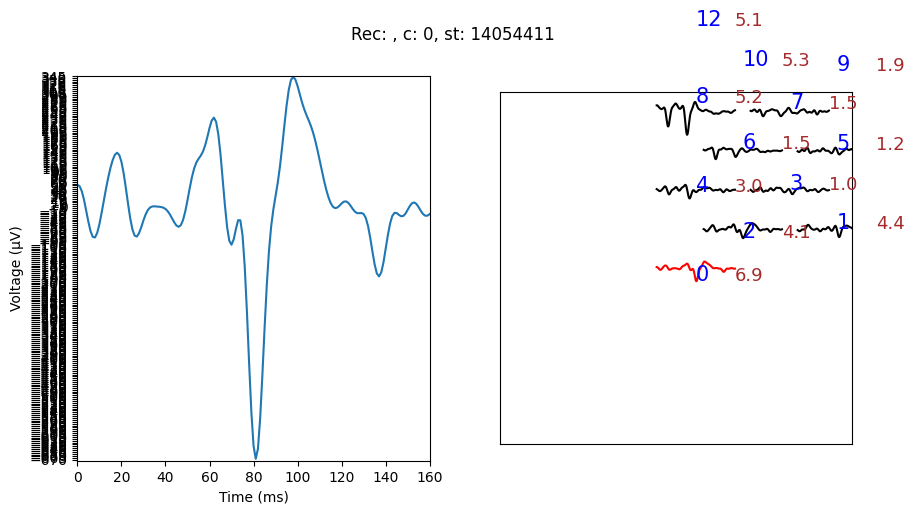

468480.36666666664
468441.5333333333 468607.0333333333
38.83333333331393 126.66666666668607


In [496]:
np.random.seed(5463)
N_BEFORE = 80
N_AFTER = 80
##
st_idx = np.random.choice(len(false_negs))
st, c1, c2 = false_negs[st_idx]

st_s = int(st * recording.get_sampling_frequency())

fig, (a0, a1) = plt.subplots(1, 2, figsize=(10, 5))
recording.plot_waveform(st_s, chan_center=unit_ks.chan,
                        n_before=80, n_after=80, subplots=(fig, (a0, a1)))
plt.show()
print(st)
print(c1, c2)
print(st-c1, c2-st)

In [495]:
propagations_merged[uid_prop]

[   ID  latency  small_window_cooccurrences  n1_n2_ratio
 0   0      0.0                      5500.0     1.000000
 1   1      0.1                      2545.0     0.975844,
    ID   latency  small_window_cooccurrences  n1_n2_ratio
 0   2  0.000000                      7016.0     1.000000
 1   4  0.000000                      3809.0     0.993479
 2   0  0.033333                      4095.0     0.998537
 3   1  0.133333                      4073.0     0.984530]

In [403]:
chan = unit_ks.chan

In [404]:
idx, closest = utils.find_closest(SPIKE_TIMES[chan], st)
print(st)
print(closest - st)
print(SPIKE_TIMES[chan][idx-1:idx+2])

895766.7
-5.599999999976717
[895761.1        895803.86666667 895815.63333333]


In [409]:
from scipy.signal import find_peaks

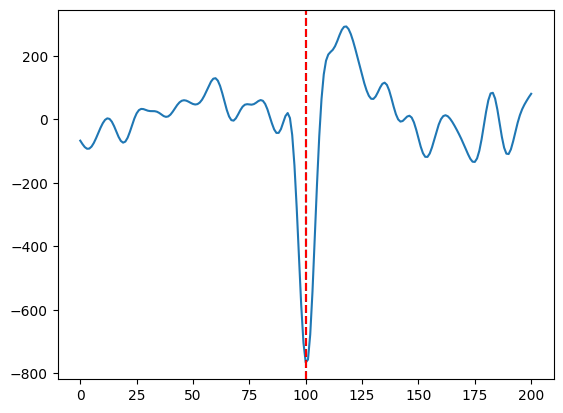

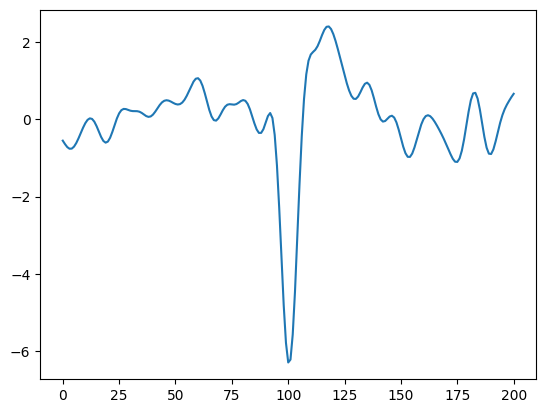

In [415]:
buffer = 100
trace = recording.get_traces_filt(st_s-buffer, st_s+buffer+1, 0).flatten()
noise = np.sqrt(np.mean(recording.get_traces_filt(st_s-500, st_s+500+1, 0).flatten() ** 2))
peaks = find_peaks(-trace, height=5 * noise)[0]

plt.plot(trace)
plt.axvline(buffer, c="black", linestyle="dashed")
for p in peaks:
    plt.axvline(p, c="red", linestyle="dashed")
plt.show()

plt.plot(trace/noise)
plt.show()

In [411]:
peaks

array([], dtype=int64)

In [412]:
trace / (5 * noise)

array([-8.64832401e-02, -1.00581735e-01, -1.12571560e-01, -1.19229130e-01,
       -1.18673988e-01, -1.10576324e-01, -9.59544778e-02, -7.67311826e-02,
       -5.52722700e-02, -3.40746529e-02, -1.56246638e-02, -2.30392022e-03,
        3.82340467e-03,  1.41832302e-03, -9.61920060e-03, -2.77549401e-02,
       -4.97865789e-02, -7.12993294e-02, -8.75539258e-02, -9.45893824e-02,
       -9.02419165e-02, -7.47814626e-02, -5.09380922e-02, -2.32405867e-02,
        3.19307181e-03,  2.40570959e-02,  3.69883440e-02,  4.20351997e-02,
        4.13044952e-02,  3.79261151e-02,  3.47367525e-02,  3.32103334e-02,
        3.30811590e-02,  3.28141935e-02,  3.06830388e-02,  2.59124096e-02,
        1.93055402e-02,  1.30464304e-02,  9.79833491e-03,  1.15680275e-02,
        1.88831054e-02,  3.06216273e-02,  4.44857813e-02,  5.78240417e-02,
        6.84164762e-02,  7.49529749e-02,  7.71456137e-02,  7.55813420e-02,
        7.14657530e-02,  6.63610548e-02,  6.19559959e-02,  5.98694980e-02,
        6.14787564e-02,  

#### Investigation
Look at which propagations overlap with and without merging

In [ ]:
prop_signal = PropSignal()
comp = Comparison()